Loading 25 files.
Loading 43 files.
Loading 43 files.
Loading 14 files.
Loading 14 files.


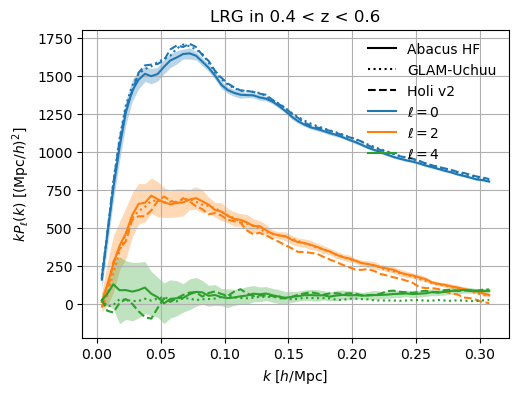

Loading 25 files.
Loading 43 files.
Loading 43 files.
Loading 14 files.
Loading 14 files.


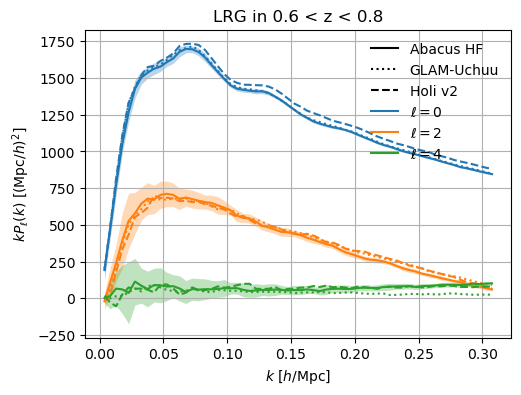

Loading 25 files.
Loading 44 files.
Loading 44 files.
Loading 14 files.
Loading 14 files.


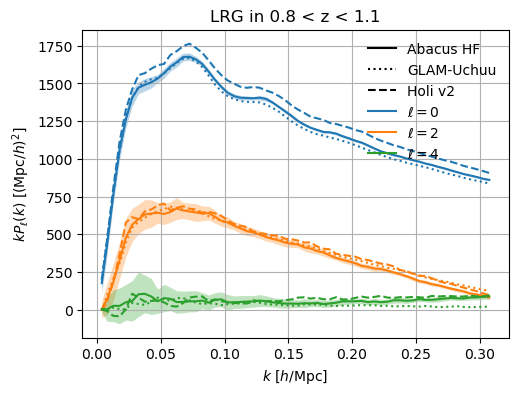

In [1]:
from pathlib import Path
from functools import partial

from matplotlib import pyplot as plt
import numpy as np

from jaxpower import Spectrum2Poles, Spectrum3Poles

from holi import get_measurement_fn as get_holi_measurement_fn
from uchuu import get_measurement_fn as get_uchuu_measurement_fn
from abacus_hf import get_measurement_fn as get_abacus_measurement_fn

plot_dir = Path('_plots')
plot_dir.mkdir(exist_ok=True)

rebin = 5
for tracer in ['BGS', 'LRG1', 'LRG2', 'LRG3', 'ELG1', 'ELG2', 'QSO'][1:4]:
    for kind in ['mesh2spectrum', 'mesh2spectrum_thetacut'][:1]:
        with_uchuu = 'BGS' in tracer or 'LRG' in tracer
        with_holi = 'LRG' in tracer or 'ELG' in tracer or 'QSO' in tracer
        with_abacus = 'LRG' in tracer or 'QSO' in tracer
        zsnap, zrange = {'BGS': (None, (0.1, 0.4)), 'LRG1': (0.5, (0.4, 0.6)), 'LRG2': (0.725, (0.6, 0.8)), 'LRG3': (0.950, (0.8, 1.1)),
                         'ELG1': (0.950, (0.8, 1.1)), 'ELG2': (None, (1.1, 1.6)), 'QSO': (1.4, (0.8, 2.1))}[tracer]
        if with_holi:
            catalog_holi_args = dict(tracer=tracer[:3], zrange=zrange)
        if with_uchuu:
            catalog_uchuu_args = dict(tracer=tracer)
        if with_abacus:
            catalog_abacus_args = dict(tracer=tracer[:3], zsnap=zsnap, zrange=zrange)
        region = 'NGC'

        def load(get_fn):
            fns = [get_fn(imock=imock, region=region, kind=kind) for imock in range(250)]
            toret = [Spectrum2Poles.load(fn) for fn in fns if Path(fn).exists()]
            print(f'Loading {len(toret):d} files.')
            return toret
        pk, cov = None, None
        if with_abacus:
            pk_abacus = Spectrum2Poles.mean(load(partial(get_abacus_measurement_fn, **catalog_abacus_args))).slice(slice(0, None, rebin))
            if pk is None: pk = pk_abacus
        if with_uchuu:
            pk_uchuu = Spectrum2Poles.mean(load(partial(get_uchuu_measurement_fn, **catalog_uchuu_args))).slice(slice(0, None, rebin))
            cov_uchuu = Spectrum2Poles.cov(load(partial(get_uchuu_measurement_fn, **catalog_uchuu_args))).slice(slice(0, None, rebin))
            if pk is None: pk = pk_uchuu
            if cov is None: cov = cov_uchuu
        if with_holi:
            pk_holi = Spectrum2Poles.mean(load(partial(get_holi_measurement_fn, **catalog_holi_args))).slice(slice(0, None, rebin))
            cov_holi = Spectrum2Poles.cov(load(partial(get_holi_measurement_fn, **catalog_holi_args))).slice(slice(0, None, rebin))
            if pk is None: pk = pk_holi
            if cov is None: cov = cov_holi
        fig, ax = plt.subplots(figsize=(5.5, 4))
        title = f'{tracer[:3]} in {zrange[0]:.1f} < z < {zrange[1]:.1f}'
        if 'thetacut' in kind: title += rf' with $\theta$-cut'
        ax.set_title(title)
        if with_abacus:
            ax.plot([], [], color='k', linestyle='-', label='Abacus HF')
        if with_uchuu:
            ax.plot([], [], color='k', linestyle=':', label='GLAM-Uchuu')
        if with_holi:
            ax.plot([], [], color='k', linestyle='--', label='Holi v2')
        for ill, ell in enumerate(pk.projs):
            color = 'C{:d}'.format(ill)
            ax.plot([], [], color=color, linestyle='-', label=f'$\ell = {ell:d}$')
            k = pk.x(projs=ell)
            std = cov.select(projs=ell, select_projs=True).std()
            ax.fill_between(k, k * (pk.view(projs=ell).real - std),
                            k * (pk.view(projs=ell).real + std),
                            color=color, alpha=0.3, linewidth=0.)
            if with_abacus:
                ax.plot(k, k * pk_abacus.view(projs=ell).real, color=color, linestyle='-')
            if with_uchuu:
                ax.plot(k, k * pk_uchuu.view(projs=ell).real, color=color, linestyle=':')
            if with_holi:
                ax.plot(k, k * pk_holi.view(projs=ell).real, color=color, linestyle='--')

        ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
        ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
        ax.legend(frameon=False, ncol=1)
        ax.grid(True)
        basename = f'spectrum_comparison_{tracer}'
        if 'thetacut' in kind: basename += '_thetacut'
        fig.savefig(plot_dir / (basename + '.png'), bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

## Bispectrum (scoccimarro)

Loading 5 files.
Loading 12 files.
Loading 12 files.


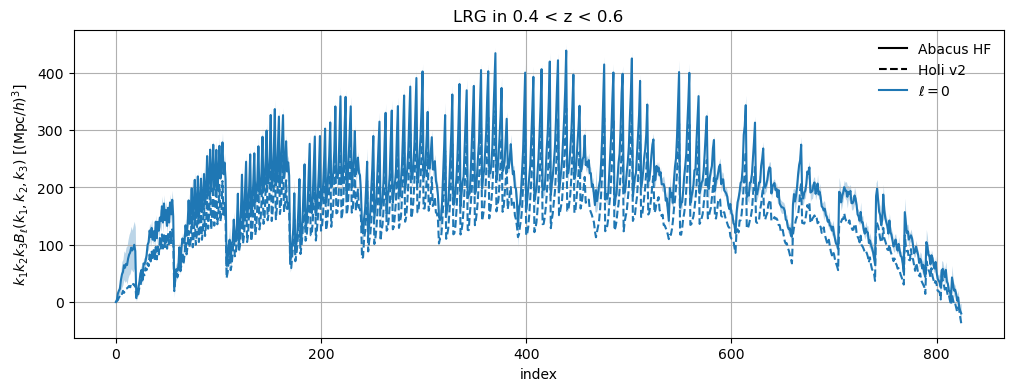

In [24]:
from pathlib import Path
from functools import partial

from matplotlib import pyplot as plt
import numpy as np

from jaxpower import Spectrum2Poles

from holi import get_measurement_fn as get_holi_measurement_fn
from uchuu import get_measurement_fn as get_uchuu_measurement_fn
from abacus_hf import get_measurement_fn as get_abacus_measurement_fn

plot_dir = Path('_plots')
plot_dir.mkdir(exist_ok=True)

rebin = 5
for tracer in ['BGS', 'LRG1', 'LRG2', 'LRG3', 'ELG1', 'ELG2', 'QSO'][1:2]:
    for kind in ['mesh3spectrum_scoccimarro']:
        with_uchuu = 'BGS' in tracer or 'LRG' in tracer
        with_holi = 'LRG' in tracer or 'ELG' in tracer or 'QSO' in tracer
        with_abacus = 'LRG' in tracer or 'QSO' in tracer
        with_uchuu = False
        zsnap, zrange = {'BGS': (None, (0.1, 0.4)), 'LRG1': (0.5, (0.4, 0.6)), 'LRG2': (0.725, (0.6, 0.8)), 'LRG3': (0.950, (0.8, 1.1)),
                         'ELG1': (0.950, (0.8, 1.1)), 'ELG2': (None, (1.1, 1.6)), 'QSO': (1.4, (0.8, 2.1))}[tracer]
        if with_holi:
            catalog_holi_args = dict(tracer=tracer[:3], zrange=zrange)
        if with_uchuu:
            catalog_uchuu_args = dict(tracer=tracer)
        if with_abacus:
            catalog_abacus_args = dict(tracer=tracer[:3], zsnap=zsnap, zrange=zrange)
        region = 'NGC'

        def load(get_fn):
            fns = [get_fn(imock=imock, region=region, kind=kind) for imock in range(250)]
            toret = [Spectrum3Poles.load(fn) for fn in fns if Path(fn).exists()]
            #print([tt._num_shotnoise[0][:10] for tt in toret])
            print(f'Loading {len(toret):d} files.')
            return toret
        pk, cov = None, None
        if with_abacus:
            pk_abacus = Spectrum3Poles.mean(load(partial(get_abacus_measurement_fn, **catalog_abacus_args)))
            if pk is None: pk = pk_abacus
        if with_uchuu:
            pk_uchuu = Spectrum3Poles.mean(load(partial(get_uchuu_measurement_fn, **catalog_uchuu_args)))
            cov_uchuu = Spectrum3Poles.cov(load(partial(get_uchuu_measurement_fn, **catalog_uchuu_args)))
            if pk is None: pk = pk_uchuu
            if cov is None: cov = cov_uchuu
        if with_holi:
            pk_holi = Spectrum3Poles.mean(load(partial(get_holi_measurement_fn, **catalog_holi_args)))
            cov_holi = Spectrum3Poles.cov(load(partial(get_holi_measurement_fn, **catalog_holi_args)))
            if pk is None: pk = pk_holi
            if cov is None: cov = cov_holi
        fig, ax = plt.subplots(figsize=(12, 4))
        title = f'{tracer[:3]} in {zrange[0]:.1f} < z < {zrange[1]:.1f}'
        if 'thetacut' in kind: title += rf' with $\theta$-cut'
        ax.set_title(title)
        if with_abacus:
            ax.plot([], [], color='k', linestyle='-', label='Abacus HF')
        if with_uchuu:
            ax.plot([], [], color='k', linestyle=':', label='GLAM-Uchuu')
        if with_holi:
            ax.plot([], [], color='k', linestyle='--', label='Holi v2')
        for ill, ell in enumerate(pk.projs[:1]):
            color = 'C{:d}'.format(ill)
            ax.plot([], [], color=color, linestyle='-', label=f'$\ell = {ell:d}$')
            x = np.prod(pk.xavg(projs=ell, method='mid'), axis=-1)
            std = cov.select(projs=ell, select_projs=True).std()
            ax.fill_between(np.arange(len(x)), x * (pk.view(projs=ell).real - std),
                            x * (pk.view(projs=ell).real + std),
                            color=color, alpha=0.3, linewidth=0.)
            if with_abacus:
                ax.plot(x * pk_abacus.view(projs=ell).real, color=color, linestyle='-')
            if with_uchuu:
                ax.plot(x * pk_uchuu.view(projs=ell).real, color=color, linestyle=':')
            if with_holi:
                ax.plot(x * pk_holi.view(projs=ell).real, color=color, linestyle='--')

        ax.set_xlabel(r'index')
        ax.set_ylabel(r'$k_1 k_2 k_3 B_{\ell}(k_1, k_2, k_3)$ [$(\mathrm{Mpc}/h)^{3}$]')
        ax.legend(frameon=False, ncol=1)
        ax.grid(True)
        basename = f'spectrum_comparison_{tracer}'
        if 'thetacut' in kind: basename += '_thetacut'
        fig.savefig(plot_dir / (basename + '.png'), bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

## Version v1

In [ ]:
from pathlib import Path
from functools import partial

from matplotlib import pyplot as plt
import numpy as np

from jaxpower import Spectrum2Poles

from holi import get_measurement_fn as get_holi_measurement_fn
from uchuu import get_measurement_fn as get_uchuu_measurement_fn
from abacus_hf import get_measurement_fn as get_abacus_measurement_fn

plot_dir = Path('_plots')
plot_dir.mkdir(exist_ok=True)

rebin = 5
for tracer in ['BGS', 'LRG1', 'LRG2', 'LRG3', 'ELG1', 'ELG2', 'QSO'][1:2]:
    for kind in ['mesh2spectrum', 'mesh2spectrum_thetacut'][:1]:
        with_uchuu = 'BGS' in tracer or 'LRG' in tracer
        with_holi = 'LRG' in tracer or 'ELG' in tracer or 'QSO' in tracer
        with_abacus = 'LRG' in tracer or 'QSO' in tracer
        zsnap, zrange = {'BGS': (None, (0.1, 0.4)), 'LRG1': (0.5, (0.4, 0.6)), 'LRG2': (0.725, (0.6, 0.8)), 'LRG3': (0.950, (0.8, 1.1)),
                         'ELG1': (0.950, (0.8, 1.1)), 'ELG2': (None, (1.1, 1.6)), 'QSO': (1.4, (0.8, 2.1))}[tracer]
        if with_holi:
            catalog_holi_args = dict(tracer=tracer[:3], zrange=zrange, version='v1')
        if with_uchuu:
            catalog_uchuu_args = dict(tracer=tracer)
        if with_abacus:
            catalog_abacus_args = dict(tracer=tracer[:3], zsnap=zsnap, zrange=zrange)
        region = 'NGC'

        def load(get_fn):
            fns = [get_fn(imock=imock, region=region, kind=kind) for imock in range(250)]
            toret = [Spectrum2Poles.load(fn) for fn in fns if Path(fn).exists()]
            print(f'Loading {len(toret):d} files.')
            return toret
        pk, cov = None, None
        if with_abacus:
            pk_abacus = Spectrum2Poles.mean(load(partial(get_abacus_measurement_fn, **catalog_abacus_args))).slice(slice(0, None, rebin))
            if pk is None: pk = pk_abacus
        if with_uchuu:
            pk_uchuu = Spectrum2Poles.mean(load(partial(get_uchuu_measurement_fn, **catalog_uchuu_args))).slice(slice(0, None, rebin))
            cov_uchuu = Spectrum2Poles.cov(load(partial(get_uchuu_measurement_fn, **catalog_uchuu_args))).slice(slice(0, None, rebin))
            if pk is None: pk = pk_uchuu
            if cov is None: cov = cov_uchuu
        if with_holi:
            pk_holi = Spectrum2Poles.mean(load(partial(get_holi_measurement_fn, **catalog_holi_args))).slice(slice(0, None, rebin))
            cov_holi = Spectrum2Poles.cov(load(partial(get_holi_measurement_fn, **catalog_holi_args))).slice(slice(0, None, rebin))
            if pk is None: pk = pk_holi
            if cov is None: cov = cov_holi
        fig, ax = plt.subplots(figsize=(5.5, 4))
        title = f'{tracer[:3]} in {zrange[0]:.1f} < z < {zrange[1]:.1f}'
        if 'thetacut' in kind: title += rf' with $\theta$-cut'
        ax.set_title(title)
        if with_abacus:
            ax.plot([], [], color='k', linestyle='-', label='Abacus HF')
        if with_uchuu:
            ax.plot([], [], color='k', linestyle=':', label='GLAM-Uchuu')
        if with_holi:
            ax.plot([], [], color='k', linestyle='--', label='Holi v1')
        for ill, ell in enumerate(pk.projs):
            color = 'C{:d}'.format(ill)
            ax.plot([], [], color=color, linestyle='-', label=f'$\ell = {ell:d}$')
            k = pk.x(projs=ell)
            std = cov.select(projs=ell, select_projs=True).std()
            ax.fill_between(k, k * (pk.view(projs=ell).real - std),
                            k * (pk.view(projs=ell).real + std),
                            color=color, alpha=0.3, linewidth=0.)
            if with_abacus:
                ax.plot(k, k * pk_abacus.view(projs=ell).real, color=color, linestyle='-')
            if with_uchuu:
                ax.plot(k, k * pk_uchuu.view(projs=ell).real, color=color, linestyle=':')
            if with_holi:
                ax.plot(k, k * pk_holi.view(projs=ell).real, color=color, linestyle='--')

        ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
        ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
        ax.legend(frameon=False, ncol=1)
        ax.grid(True)
        basename = f'spectrum_comparison_v1_{tracer}'
        if 'thetacut' in kind: basename += '_thetacut'
        fig.savefig(plot_dir / (basename + '.png'), bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

In [ ]:
from holi import get_clustering_rdzw, get_data_fn, get_randoms_fn
imock = 201
tracer = 'LRG'
region = 'NGC'
fn = get_data_fn(imock=imock, tracer=tracer)
data = get_clustering_rdzw(fn, imock=imock, region=region)
fn = get_randoms_fn(tracer=tracer, imock=imock, region=region)
randoms = get_clustering_rdzw(fn, region=region)

def plot_healpix(ra, dec, nside=64, title="Binned RA/DEC Map", show=True):
    import healpy as hp
    npix = hp.nside2npix(nside)
    # Convert to theta (colatitude) and phi (longitude) in radians
    theta = np.radians(90.0 - dec)
    phi = np.radians(ra + 180.)
    # Get pixel indices
    pix = hp.ang2pix(nside, theta, phi)
    # Bin into HEALPix map
    healpix_map = np.bincount(pix, minlength=npix)
    # Mask unseen pixels
    healpix_map = np.where(healpix_map == 0, hp.UNSEEN, healpix_map)
    # Plot
    hp.mollview(healpix_map, title=title, unit="Counts", cmap="viridis")
    if show:
        plt.show()

plot_healpix(*data[:2])
plot_healpix(*randoms[:2])